In [73]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

In [74]:
devices = tf.config.experimental.list_physical_devices("GPU")
for device in devices:
    tf.config.experimental.set_memory_growth(device, enable=True)

In [75]:
image_path = "./data_partitioned/image/test"
mask_path = "./data_partitioned/mask/test"

In [76]:
filenames = os.listdir(image_path)
filenames[:5]

['120_image_26.png',
 '120_image_32.png',
 '120_image_69.png',
 '120_image_77.png',
 '120_image_82.png']

In [77]:
def load_image(image_path, mask_path):
    image, mask = tf.io.read_file(image_path), tf.io.read_file(mask_path)
    image, mask = tf.image.decode_png(image), tf.image.decode_png(mask, channels=1)
    image, mask = tf.cast(image, tf.float32), tf.cast(mask, tf.float32)
    image, mask = tf.image.resize(image, (224, 224)), tf.image.resize(mask, (224, 224))
    image, mask = image / 255.0, mask/255.0
    if image.shape[-1] == 4:
        # Remove the alpha channel (last channel)
        image = image[:, :, :3]
    return image, mask

In [78]:
image, mask = load_image(os.path.join(image_path, filenames[0]), os.path.join(mask_path, filenames[0]))
image.shape, mask.shape

(TensorShape([224, 224, 3]), TensorShape([224, 224, 1]))

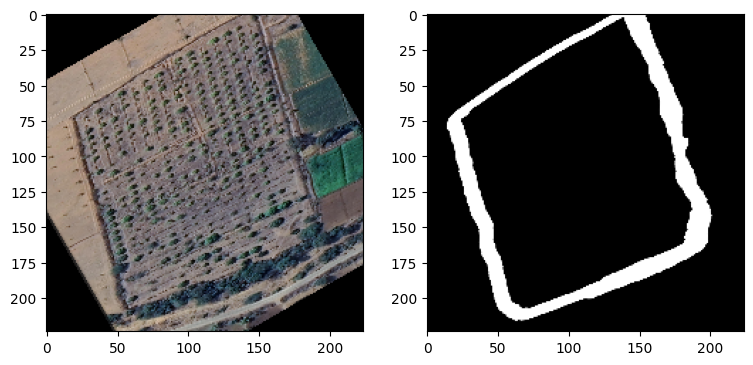

In [79]:
fig, axes = plt.subplots(1, 2, figsize = (9,9))
axes[0].imshow(image)
axes[1].imshow(mask, cmap = "gray")

In [80]:
import keras
from keras.layers import Conv2D, Input, BatchNormalization, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from keras.models import Model


In [81]:
inputs = Input((224, 224, 3))

c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.1)(c3)
c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.1)(c4)
c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D((2, 2))(c4)

c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.1)(c5)
c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5 = BatchNormalization()(c5)
p5 = MaxPooling2D((2, 2))(c5)

u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = concatenate([u9, c1])
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
c9 = BatchNormalization()(c9)


outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [82]:
unet_model = Model(inputs=[inputs], outputs=[outputs])
unet_model.compile(optimizer='adam', loss='binary_crossentopy', metrics=['accuracy'])
unet_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 224, 224,  │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 224, 224,  │      9,248 │ dropout_27[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_58[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_15… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_59[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 112, 112,  │     36,928 │ dropout_28[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_60[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 56, 56,    │     73,856 │ max_pooling2d_16… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_61[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 56, 56,    │    147,584 │ dropout_29[0][0]

 Total params: 7,031,793 (26.82 MB)

 Trainable params: 7,025,905 (26.80 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [83]:
x_train = [os.path.join(image_path, i) for i in filenames]
y_train = [os.path.join(mask_path, i) for i in filenames]

validation data

In [84]:
val_image_path = "./data_partitioned/image/val"
val_mask_path = "./data_partitioned/mask/val"
val_filenames = os.listdir(val_image_path)
x_val = [os.path.join(val_image_path, i) for i in val_filenames]
y_val = [os.path.join(val_mask_path, i) for i in val_filenames]

test data

In [85]:
test_image_path = "./data_partitioned/image/test"
test_mask_path = "./data_partitioned/mask/test"
test_filenames = os.listdir(test_image_path)
x_test = [os.path.join(test_image_path, i) for i in test_filenames]
y_test = [os.path.join(test_mask_path, i) for i in test_filenames]

In [86]:
training_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
training_dataset = training_dataset.map(load_image).shuffle(min(1000, len(x_train))).batch(8)

In [87]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.map(load_image).batch(1)

In [88]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(load_image).batch(1)

In [89]:
loss = tf.keras.losses.Dice(
    reduction='sum_over_batch_size', name='dice'
)
optimizer = tf.keras.optimizers.Adam()

In [90]:
@tf.function
def train_step(x, y):
    with tf.GradientTape(persistent=True) as tape:
        pred = unet_model(x, training=True)
        loss_ = loss(pred, y)
    gradients = tape.gradient(loss_, unet_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, unet_model.trainable_variables))
    return loss_

In [91]:
epochs = 20
losses = []
for epoch in range(1, epochs + 1):
    batch_loss = []
    for train_x, train_y in training_dataset:
        loss_ = train_step(train_x, train_y)
        batch_loss.append(loss_)
    val_losses = []
    for val_x, val_y in val_dataset:
        val_losses.append(loss(unet_model(val_x, training = False), val_y))
    losses.append(np.mean(batch_loss))
    print(f"Completed Epoch: {epoch} Training loss: {np.mean(batch_loss)} Validation loss: {np.mean(val_losses)}")

Completed Epoch: 1 Training loss: 0.79139643907547 Validation loss: 0.828961193561554
Completed Epoch: 2 Training loss: 0.7369362115859985 Validation loss: 0.7804709672927856
Completed Epoch: 3 Training loss: 0.6677613258361816 Validation loss: 0.7981066703796387
Completed Epoch: 4 Training loss: 0.604892373085022 Validation loss: 0.8023756742477417
Completed Epoch: 5 Training loss: 0.5729396939277649 Validation loss: 0.8799039721488953
Completed Epoch: 6 Training loss: 0.5368029475212097 Validation loss: 0.7970458269119263
Completed Epoch: 7 Training loss: 0.501251220703125 Validation loss: 0.7724317312240601
Completed Epoch: 8 Training loss: 0.4656873643398285 Validation loss: 0.7565109133720398
Completed Epoch: 9 Training loss: 0.4482542872428894 Validation loss: 0.8908465504646301
Completed Epoch: 10 Training loss: 0.41244634985923767 Validation loss: 0.8331882357597351
Completed Epoch: 11 Training loss: 0.39543652534484863 Validation loss: 0.787830114364624
Completed Epoch: 12 Tra

In [92]:
x, y = next(iter(test_dataset))
x.shape, y.shape

(TensorShape([1, 224, 224, 3]), TensorShape([1, 224, 224, 1]))

In [93]:
pred = unet_model(x)
pred.shape

TensorShape([1, 224, 224, 1])

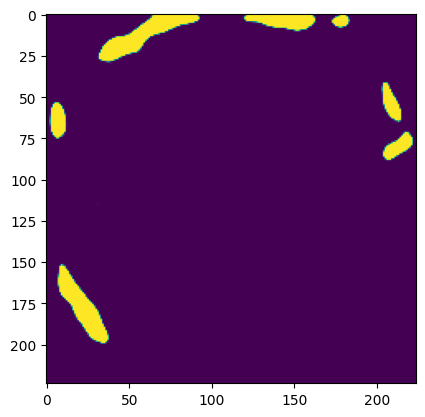

In [94]:
plt.imshow(pred[0])

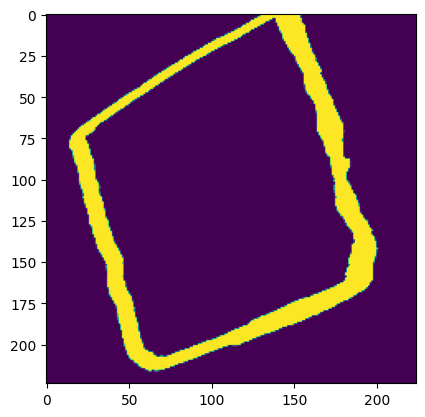

In [95]:
plt.imshow(y[0])

In [ ]:
pytouch vesnet